In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import statsmodels.api as sm
import lightgbm as lgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc
)

# Configuration esthétique pour les graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
import mlflow
from scipy import stats
from equipy.fairness import FairWasserstein
from equipy.metrics import unfairness
from Functions_fair_model import *
from Functions_linear_model_under_DP import *
from scipy.stats import kstest, ks_2samp



In [2]:
pred_cols = {
                "Benchmark":        "y_input_reg",
                "Benchmark groupe": "y_skl_group",
                "EquiPy":           "y_score_equipy",
                "Riken":            "y_pred_riken",
                "Fair_linear":      "y_pred_fair"
}

Objectives 
- find suitables target variables 
- bootstrap of 30
- RMSE, unfairness, R2

## 2) Test sur __GOSSIS__

In [3]:
chemin_df_labeled = "labeled_dataset/labeled.csv"
chemin_df_unlabeled = "unlabeled_dataset/unlabeled.csv"
df_labeled = pd.read_csv(chemin_df_labeled)
df_unlabeled = pd.read_csv(chemin_df_unlabeled)

In [4]:
labeled_data, blackbox_scores_labeled, s_labeled, unlabeled_data, blackbox_scores_unlabeled, s_unlabeled = load_Gossis_data.load_gossis_data(
    labeled=df_labeled,
    unlabeled=df_unlabeled,
    target_feature="hospital_death",
    sensitive_group="African American",
    blackbox_feature="apache_4a_hospital_death_prob"
)

ÉTAPE 1 : CHARGEMENT ET NETTOYAGE INITIAL DES DONNÉES

Dimensions initiales : Labeled=(91713, 180), Unlabeled=(39308, 180)

Filtrage des colonnes (>10% de NaN). 81 colonnes restantes.
-> Dimensions après nettoyage des NaN : Labeled=(56451, 81), Unlabeled=(23100, 80)

Encodage du groupe sensible 'African American' dans la colonne 'ethnicity'...
-> Valeurs possibles : [-1  1]

Extraction des scores prédéfinis de 'apache_4a_hospital_death_prob'...


In [5]:
def identify_variable_types(df, columns=None, discrete_threshold=10, unique_ratio_threshold=0.05):
    """
    Identifie si les variables sont continues ou discrètes.
    
    Paramètres:
    - df: DataFrame pandas
    - columns: Liste des colonnes à vérifier (None = toutes les colonnes)
    - discrete_threshold: Nombre maximum de valeurs uniques pour considérer une variable comme discrète
    - unique_ratio_threshold: Ratio minimum de valeurs uniques/total pour considérer une variable comme continue
    
    Retourne:
    - Un dictionnaire avec les résultats et un DataFrame résumant les caractéristiques
    """
    if columns is None:
        columns = df.columns
    
    results = {
        'continuous': [],
        'discrete': [],
        'categorical': [],
        'binary': [],
        'summary': []
    }
    
    for col in columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            results['categorical'].append(col)
            continue
            
        n_unique = df[col].nunique()
        n_total = len(df[col])
        unique_ratio = n_unique / n_total
        
        # Collecter les statistiques
        summary = {
            'column': col,
            'dtype': df[col].dtype,
            'n_unique': n_unique,
            'unique_ratio': unique_ratio,
            'min': df[col].min(),
            'max': df[col].max(),
            'has_decimals': any(x % 1 != 0 for x in df[col].dropna().sample(min(1000, len(df[col]))).values)
        }
        results['summary'].append(summary)
        
        # Classifier la variable
        if n_unique == 2:
            results['binary'].append(col)
            results['discrete'].append(col)
        elif n_unique <= discrete_threshold or unique_ratio < unique_ratio_threshold:
            results['discrete'].append(col)
        else:
            # Vérifier si la variable a des valeurs décimales
            if summary['has_decimals']:
                results['continuous'].append(col)
            else:
                # Si beaucoup de valeurs uniques mais toutes entières, c'est probablement un ID ou une variable discrète
                if n_unique > 100:
                    results['continuous'].append(col)  # Probablement un ID numérique
                else:
                    results['discrete'].append(col)
    
    # Créer un DataFrame de résumé
    summary_df = pd.DataFrame(results['summary'])
    if not summary_df.empty:
        summary_df['classification'] = summary_df['column'].apply(
            lambda x: 'binary' if x in results['binary'] 
                     else 'discrete' if x in results['discrete'] 
                     else 'continuous' if x in results['continuous']
                     else 'categorical'
        )
    
    return results, summary_df

# Exemple d'utilisation
# results, summary_df = identify_variable_types(df, columns=['age', 'income', 'gender'])
# print(summary_df)


In [6]:
def select_uncorrelated_features(df, threshold=0.8):
    """
    Sélectionne les variables qui ne sont pas fortement corrélées entre elles.
    
    Args:
        df: DataFrame contenant les variables
        threshold: Seuil de corrélation (défaut: 0.8)
        
    Returns:
        Liste des noms de variables à conserver
    """
    # Calculer la matrice de corrélation
    corr_matrix = df.corr().abs()
    
    # Créer une matrice triangulaire supérieure
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Identifier les colonnes à supprimer (corrélées au-dessus du seuil)
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Colonnes à conserver
    to_keep = [column for column in df.columns if column not in to_drop]
    
    return to_keep

In [7]:
list_continuous_candidates = labeled_data.describe().columns.to_list()
results, summary_df = identify_variable_types(labeled_data, columns=list_continuous_candidates)
list_columns_to_test = summary_df[summary_df['n_unique']>70]['column'].to_list()
numerical_features_to_test = [i for i in list_columns_to_test if i not in ["apache_2_bodysystem", "icu_admit_source",'encounter_id','patient_id', 'hospital_id']]
list_less_correlated_var = select_uncorrelated_features(labeled_data[numerical_features_to_test])

In [11]:
# Listes de variables sélectionnées
categorical_features = ["apache_2_bodysystem", "icu_admit_source"]
ordinal_features = ["gender"]
numerical_features = list_less_correlated_var
# [
#     "age", "bmi", "immunosuppression",
#     "d1_diasbp_noninvasive_max", "d1_sysbp_noninvasive_max",
#     "d1_heartrate_min", "resprate_apache", "d1_sysbp_min",
#     "d1_spo2_min", "d1_glucose_max", "pre_icu_los_days", "map_apache","apache_4a_hospital_death_prob"
# ]
sensitive_feature="ethnicity"
target_feature = "hospital_death"

all_selected_features = categorical_features + ordinal_features + numerical_features + [sensitive_feature, target_feature]
df_analysis = labeled_data[all_selected_features].copy()

In [12]:
labeled_data_preprocessed, unlabeled_data_preprocessed, data_orig_names = load_Gossis_data.preprocess_features(
    labeled_data,
    unlabeled_data,
    target_feature,
    sensitive_feature,
    categorical_features,
    ordinal_features,
    numerical_features, # Renommé de no_change_features
    do_scale=True
)


ÉTAPE 2 : PRÉTRAITEMENT DES VARIABLES (ENCODAGE)

Caractéristiques originales (échantillon) :
  apache_2_bodysystem      icu_admit_source gender   age    bmi  height  \
0      Cardiovascular                 Floor      M  68.0  22.73   180.3   
1         Respiratory                 Floor      F  77.0  27.42   160.0   
5          Neurologic  Accident & Emergency      M  67.0  27.56   190.5   

   pre_icu_los_days  apache_3j_diagnosis  heart_rate_apache  map_apache  ...  \
0          0.541667               502.01              118.0        40.0  ...   
1          0.927778               203.01              120.0        46.0  ...   
5          0.000694               403.01              113.0       130.0  ...   

   h1_spo2_min  h1_sysbp_max  d1_creatinine_max  d1_glucose_max  \
0         74.0         131.0               2.51           168.0   
1         70.0          95.0               0.71           145.0   
5         97.0         143.0               0.71           156.0   

   d1_glucose_

In [13]:
def log_mlflow_run(y,s_variable,X_features, model,preprocessing, y_pred_model,param, 
                   train_data, test_data, pool_data,
                   list_predictions_plot, list_descriptions_plot,
                   log_model_bool=False, model_to_log=None, comment=""):
    """
    Fonction pour démarrer une exécution MLflow, enregistrer les paramètres et les métriques.

    Args:
        y (str): La variable cible.
        model (str): Nom du modèle. 
        preprocessing (str): Type d'entraînement.
        y_pred_model (str): Nom de la colonne contenant les prédictions.
        param (dict): Les paramètres du modèle.
        test_data (DataFrame): Les données de test.
        log_model_bool (bool): Si True, enregistre le modèle au format pickle dans MLflow.
    """
    # Démarrer une exécution MLflow
    with mlflow.start_run() as run:
        mlflow.set_tag("mlflow.runName", f"{y}__{s_variable}")
        
        # 1. Ajouter un commentaire sur l'expérience comme tag
        if comment:
            mlflow.set_tag("comment", comment)
        
        # 2. Enregistrer les paramètres
        # Ajouter les variables explicatives en paramètres
        param['X_features']=X_features
        mlflow.log_params(param)

        # 3. Calculer et enregistrer les métriques
        y_true = test_data[y]
        y_pred = test_data[f'{y_pred_model}']
        y_sensitive_feature = pd.DataFrame({f'{s_variable}': test_data[f'{s_variable}'].to_list()})

        mlflow.log_metric("r2_score", r2_score(y_true, y_pred))
        mlflow.log_metric("mae", mean_absolute_error(y_true, y_pred))
        mlflow.log_metric("mse", mse_loss(y_true, y_pred))

        unfairness_value = unfairness(np.array(y_pred.to_list()), y_sensitive_feature)
        mlflow.log_metric("unfairness", unfairness_value)

        unfairness_data_value = unfairness(np.array(y_true.to_list()), y_sensitive_feature)
        mlflow.log_metric("unfairness_data", unfairness_data_value)

        # Calculer et enregistrer la statistique KS
        ks_stat_y = kstest(rvs=test_data[test_data[f'{s_variable}']==0][y], cdf=test_data[test_data[f'{s_variable}']==1][y], alternative='two-sided').statistic
        ks_stat_pred = kstest(rvs=test_data[test_data[f'{s_variable}']==0][str(y_pred_model)], cdf=test_data[test_data[f'{s_variable}']==1][str(y_pred_model)], alternative='two-sided').statistic
        mlflow.log_metric("ks_stat_y", ks_stat_y)
        mlflow.log_metric("ks_stat_pred", ks_stat_pred)

        # 4. Enregistrer des graphiques
        plot_path = "plot_prediction_en_fonction_du_vrai_label.png"
        Results_analysis.plot_prediction_true_label(y, S_variable,test_dataset, list_predictions_plot, list_descriptions_plot, save_path=plot_path)
        mlflow.log_artifact(plot_path)

        plot_distrib_path = "plot_predictions_densities.png"
        Results_analysis.plot_prediction_density(S_variable, test_dataset, [y] + list_predictions_plot, [y] +list_descriptions_plot,save_path=plot_distrib_path)
        mlflow.log_artifact(plot_distrib_path)


        # 5. Enregistrer des paramètres supplémentaires
        mlflow.log_param("model", f"{model}")
        mlflow.log_param("preprocessing", f"{preprocessing}")

        # Enregistrer le modèle si log_model_bool est True
        if log_model_bool :
            # Enregistrer le modèle au format pickle
            mlflow.sklearn.log_model(model_to_log, "model")

        # Enregistrer les datasets
        test_data.to_csv("test_data.csv", index=False)
        mlflow.log_artifact("test_data.csv")

        train_data.to_csv("train_data.csv", index=False)
        mlflow.log_artifact("train_data.csv")

        if pool_data is not None: 
            pool_data.to_csv("pool_data.csv", index=False)
            mlflow.log_artifact("pool_data.csv")

In [14]:
labeled_data_preprocessed.replace({'ethnicity': {1: 2}},inplace=True)
labeled_data_preprocessed.replace({'ethnicity': {-1: 1}},inplace=True)
unlabeled_data_preprocessed.replace({'ethnicity': {1: 2}},inplace=True)
unlabeled_data_preprocessed.replace({'ethnicity': {-1: 1}},inplace=True)
labeled_data_preprocessed['ethnicity'].value_counts()

ethnicity
1    50345
2     6106
Name: count, dtype: int64

__Example 1 : h1_sysbp_max__

In [18]:
train_dataset, test_dataset = train_test_split(labeled_data_preprocessed, test_size=0.3)
# train_dataset,pool_dataset = train_test_split(train_dataset, test_size=0.2)
bool_columns = unlabeled_data_preprocessed.select_dtypes(include='bool').columns.tolist()
unlabeled_data_preprocessed[bool_columns] = unlabeled_data_preprocessed[bool_columns].astype(int)
train_dataset[bool_columns] = train_dataset[bool_columns].astype(int)
test_dataset[bool_columns] = test_dataset[bool_columns].astype(int)

In [ ]:
def plot_graph(test_dataset,y, S_variable):
    # Select only the models we want to display
    display_models = ['y_input_reg', 'y_pred_bias', 'y_pred_riken', 'y_pred_fair']
    display_titles = ['Bayes', 'CS_22', 'FS_23', 'Our model']
    
    # Create figure with 4 subplots (one for each selected model)
    fig, axes = plt.subplots(1, len(display_models), figsize=(12, 3))
    # fig.suptitle(f"Conditional prediction distributions (t={t_unfair})", fontsize=12)
    
    # For each model
    for i, model in enumerate(display_models):
        if model in test_dataset.columns:
            # Calculate metrics for the title
            GWR2 = Metrics.group_weighted_r2(test_dataset,y,model, S_variable)
            rmse=round(np.sqrt(mean_squared_error(test_dataset[y], test_dataset[model])),5)
            w2_unfairness = Metrics.unfairness_computation(model, S_variable, test_dataset)
            
            # Plot histograms
            sns.histplot(
                test_dataset[test_dataset[S_variable]==1][model],
                label='Group 1',
                stat='density',
                bins=15,
                alpha=0.4,
                ax=axes[i])
            sns.histplot(
                test_dataset[test_dataset[S_variable]==2][model],
                label='Group 2',
                stat='density',
                bins=15,
                alpha=0.4,
                ax=axes[i])
            
            # Set title with metrics
            axes[i].set_title(f"{display_titles[i]}\nRMSE: {rmse}, GWR²: {GWR2:.3f}, U: {w2_unfairness:.3f}", fontsize=10)
            
            # Clean up axes
            axes[i].set_xlabel("Prediction", fontsize=9)
            if i == 0:
                axes[i].set_ylabel("Density", fontsize=9)
                axes[i].legend(fontsize=8)
            else:
                axes[i].set_ylabel("")
                # axes[i].get_legend().remove()  # Remove redundant legends
            
            # Reduce tick label size
            axes[i].tick_params(axis='both', which='major', labelsize=8)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save figure if needed
    # plt_path = f"{title}.png"
    # plt.savefig(plt_path, dpi=300, bbox_inches='tight')
    # return plt_path
    
    return fig


In [22]:
y = 'h1_sysbp_max'
S_variable='ethnicity'
X_features = labeled_data_preprocessed.drop(columns=[S_variable,y,'hospital_death']).columns.to_list()
# train_dataset, test_dataset, pool_dataset = perform_min_max_scaler(train_dataset[X_features + [S_variable,y]], test_dataset[X_features + [S_variable,y]], unlabeled_data_preprocessed, S_variable, y)

coef_input_model, param_dictionnary, input_model, test_dataset= Fair_model.predict_fair_linear_score(train_dataset,unlabeled_data_preprocessed,test_dataset,S_variable,y,X_features, True, False , False)
Benchmark_model.benchmark_equipy(train_dataset, test_dataset, 'y_input_reg', S_variable)
param_riken = riken_prediction(train_dataset, test_dataset, S_variable, X_features, y)
coef_sklearn_o, coef_sklearn_z = Benchmark_model.model_benchmark_group(train_dataset, test_dataset, y, S_variable,X_features,True, False)

Benchmark_model.weighted_group_intercepts(train_dataset,test_dataset,
                                    X_features,y,S_variable,
                                    True)

param_pred ={}
param_pred['y_input_reg']=param_dictionnary
param_pred['y_pred_fair']=param_dictionnary
param_pred['y_score_equipy']={}
param_pred['y_pred_riken']=param_riken

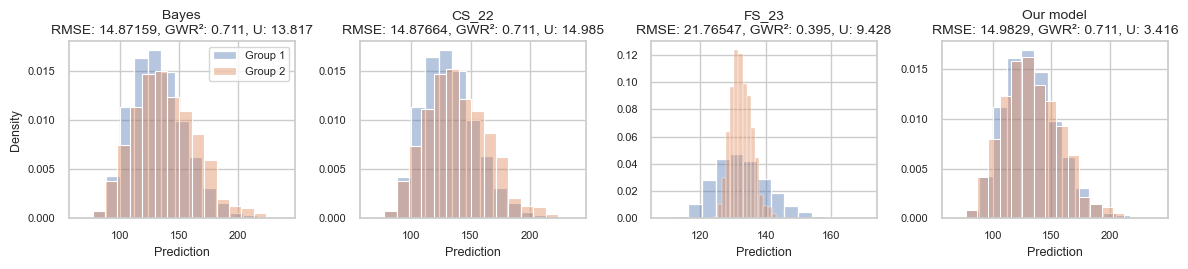

In [23]:
fig = plot_graph(test_dataset,y, S_variable)

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def create_metrics_dataframe(test_dataset, model_columns, display_names, y, S_variable):
    """
    Crée un DataFrame avec les métriques (unfairness, RMSE, R²) pour chaque modèle.
    
    Args:
        test_dataset: DataFrame contenant les prédictions et les valeurs réelles
        model_columns: Liste des noms de colonnes contenant les prédictions des modèles
        display_names: Liste des noms d'affichage correspondant aux modèles
    
    Returns:
        DataFrame avec les métriques pour chaque modèle
    """
    # Vérifier que les listes ont la même longueur
    if len(model_columns) != len(display_names):
        raise ValueError("Les listes model_columns et display_names doivent avoir la même longueur")
    
    # Créer un dictionnaire pour stocker les résultats
    results = {
        'Model': display_names,
        'Unfairness': [],
        'RMSE': [],
        'R²': []
    }
    
    # Supposons que 'y_true' est la colonne contenant les valeurs réelles
    y_true = test_dataset[f'{y}']
    
    # Pour chaque modèle, calculer les métriques
    for model_col in model_columns:
        if model_col not in test_dataset.columns:
            raise ValueError(f"La colonne {model_col} n'existe pas dans le DataFrame")
        
        y_pred = test_dataset[model_col]
        
        # Calculer l'unfairness
        unfairness = Metrics.unfairness_computation(model_col, S_variable, test_dataset)
        
        # Calculer RMSE
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        # Calculer R²
        r2 = r2_score(y_true, y_pred)
        
        # Ajouter les résultats au dictionnaire
        results['Unfairness'].append(unfairness)
        results['RMSE'].append(rmse)
        results['R²'].append(r2)
    
    # Créer le DataFrame final
    metrics_df = pd.DataFrame(results)
    
    # Formater les nombres pour une meilleure lisibilité
    metrics_df['Unfairness'] = metrics_df['Unfairness'].map('{:.6f}'.format)
    metrics_df['RMSE'] = metrics_df['RMSE'].map('{:.4f}'.format)
    metrics_df['R²'] = metrics_df['R²'].map('{:.4f}'.format)
    
    return metrics_df

In [ ]:
# Utilisation de la fonction
model_columns = ['y_pred_fair', 'y_input_reg', 'y_score_equipy', 'y_pred_riken', 'y_pred_bias']
display_names = ['Our model', 'Bayes model', 'Equipy', 'FS_23', 'CS_22']

metrics_df = create_metrics_dataframe(test_dataset, model_columns, display_names,y, S_variable)

metrics_df


__Example 2 : h1_diasbp_max__ with ethnicity

In [81]:
train_dataset, test_dataset = train_test_split(labeled_data_preprocessed, test_size=0.3)
# train_dataset,pool_dataset = train_test_split(train_dataset, test_size=0.2)
bool_columns = unlabeled_data_preprocessed.select_dtypes(include='bool').columns.tolist()
unlabeled_data_preprocessed[bool_columns] = unlabeled_data_preprocessed[bool_columns].astype(int)
train_bool= train_dataset.select_dtypes(include='bool').columns.tolist()
test_bool=test_dataset.select_dtypes(include='bool').columns.tolist()
train_dataset[train_bool] = train_dataset[train_bool].astype(int)
test_dataset[test_bool] = test_dataset[test_bool].astype(int)

In [82]:
y = 'apache_4a_hospital_death_prob' #'h1_diasbp_max'
S_variable='ethnicity'
X_features = labeled_data_preprocessed.drop(columns=[S_variable,y,'hospital_death']).columns.to_list()
# train_dataset, test_dataset, pool_dataset = perform_min_max_scaler(train_dataset[X_features + [S_variable,y]], test_dataset[X_features + [S_variable,y]], unlabeled_data_preprocessed, S_variable, y)

coef_input_model, param_dictionnary, input_model, test_dataset= Fair_model.predict_fair_linear_score(train_dataset,unlabeled_data_preprocessed,test_dataset,S_variable,y,X_features, True, False , True)
Benchmark_model.benchmark_equipy(train_dataset, test_dataset, 'y_input_reg', S_variable)
param_riken = riken_prediction(train_dataset, test_dataset, S_variable, X_features, y)
coef_sklearn_o, coef_sklearn_z = Benchmark_model.model_benchmark_group(train_dataset, test_dataset, y, S_variable,X_features,True, False)

Benchmark_model.weighted_group_intercepts(train_dataset,test_dataset,
                                    X_features,y,S_variable,
                                    True)
param_pred ={}
param_pred['y_input_reg']=param_dictionnary
param_pred['y_pred_fair']=param_dictionnary
param_pred['y_score_equipy']={}
param_pred['y_pred_riken']=param_riken

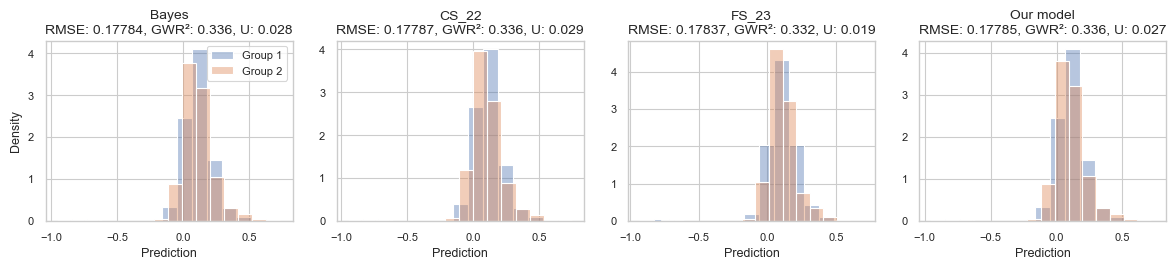

In [83]:
fig = plot_graph(test_dataset,y, S_variable)

In [27]:
model_columns = ['y_pred_fair', 'y_input_reg', 'y_score_equipy', 'y_pred_riken', 'y_pred_bias']
display_names = ['Our model', 'Bayes model', 'Equipy', 'FS_23', 'CS_22']
metrics_df = create_metrics_dataframe(test_dataset, model_columns, display_names,y, S_variable)
metrics_df

NameError: name 'create_metrics_dataframe' is not defined

__Exemple 3 : heart_rate_apache__

### __Log MLFlow__

In [28]:
list_predictions = ['y_input_reg', 'y_pred_fair', 'y_score_equipy', 'y_pred_riken']
list_description = ['Regression Lineaire Input','Modèle Lineaire Fair','Equipy','Riken']
S_variable='ethnicity'
train_dataset, test_dataset = train_test_split(labeled_data_preprocessed, test_size=0.2)
train_dataset,pool_dataset = train_test_split(train_dataset, test_size=0.2)

0) vérifier la perf sur quelques variables rapidos
1) vérifier que les perf sot les memes avec la liste
2) ou bien tester sans min max scaler, vérifier les coef, trouver le bug


TO do MLFLow
- ajouter la distance W2
- ajouter les courbes de y et prédictions en artefact pour comprendre

In [37]:
import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# Create a new MLflow Experiment
mlflow.set_experiment("AAAI Real Dataset")

<Experiment: artifact_location='mlflow-artifacts:/534171740069015196', creation_time=1752927357913, experiment_id='534171740069015196', last_update_time=1752927357913, lifecycle_stage='active', name='AAAI Real Dataset', tags={}>

In [31]:
bool_columns = unlabeled_data_preprocessed.select_dtypes(include='bool').columns.tolist()
unlabeled_data_preprocessed[bool_columns] = unlabeled_data_preprocessed[bool_columns].astype(int)
bool_columns = labeled_data_preprocessed.select_dtypes(include='bool').columns.tolist()
labeled_data_preprocessed[bool_columns] = labeled_data_preprocessed[bool_columns].astype(int)

In [32]:
labeled_data_preprocessed['ethnicity'].value_counts()

ethnicity
1    50345
2     6106
Name: count, dtype: int64

In [38]:
y= 'h1_diasbp_max'
S_variable ='ethnicity'
X_features=labeled_data_preprocessed.drop(columns=[S_variable,'h1_diasbp_max','hospital_death']).columns.to_list()

In [42]:
def run_experiment(data_name, y, S_variable, X_features,data, n_simulations):
    """
    Exécute une expérience en faisant varier un paramètre spécifique.
    
    Args:
        varying_param: Le nom du paramètre à faire varier ('t_values', 'p_mu_bias', ou 'p_sigma_bias')
        param_values: Liste des valeurs pour le paramètre variable
        fixed_params: Dictionnaire des paramètres fixes
    
    Returns:
        all_results: Dictionnaire contenant les résultats pour chaque valeur du paramètre
    """
    # Liste des modèles et métriques
    models = ['y_pred_fair', 'y_input_reg', 'y_score_equipy', 'y_pred_riken', 'y_pred_bias']
    metrics = ['r2', 'GRW2','mae', 'rmse', 'unfairness_W2', 'unfairness_W1', 'ks_stat','beta_0_NoStd','beta_NoStd','gamma_NoStd',
           'beta_0_1_Std','beta_0_2_Std','beta_1_Std','beta_2_Std','gamma_Std',
            'fair_intercept_1_NoStd', 'fair_intercept_2_NoStd', 'beta_1_NoStd','beta_2_NoStd', 
            'fair_intercept_Std','beta_Std',
            'riken_intercept_Std']
    param_riken_null=0

    # Dictionnaire pour stocker tous les résultats
    all_results = {}

    # Boucle sur chaque valeur du paramètre variable
    t_results = {model: {metric: [] for metric in metrics} for model in models}
        
    # Effectuer n_simulations pour cette valeur du paramètre
    for bootstrap in tqdm(range(n_simulations)):

            # Préparation des données
        train_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=bootstrap)
        train_dataset,pool_dataset = train_test_split(train_dataset, test_size=0.2, random_state=bootstrap)
        
        for s in data[S_variable].unique():
            # print(len(train_dataset[train_dataset[S_variable]==s]//3), 12*len(X_features))
            if len(train_dataset[train_dataset[S_variable]==s]//3) < 12*len(X_features):
                print(f'normalized_beta_{s}__and__norm_beta_{s}__are_set_to_0')
                param_riken_null +=1
            # print(len(train_dataset[train_dataset[S_variable]==s]//2),18*len(X_features))
            if len(train_dataset[train_dataset[S_variable]==s]//2) < 18*len(X_features):
                print(f'beta_{s}_bis__is_set_to_0')
                param_riken_null +=1

        y_sensitive_feature = pd.DataFrame({f"{S_variable}": test_dataset[S_variable].to_list()})
        unique_groups = test_dataset[S_variable].unique()
            
        # Modèle Fair Linear
        coef_input_model, param_dictionnary, input_model, test_dataset = Fair_model.predict_fair_linear_score(
                train_dataset, pool_dataset, test_dataset, S_variable, y, X_features, True, False, False
            )

        # Modèle EquiPy
        Benchmark_model.benchmark_equipy(train_dataset, test_dataset, 'y_input_reg', S_variable)
            
        # Modèle Riken
        dictionnary_riken_raw = riken_prediction(train_dataset, test_dataset, S_variable, X_features, y)
            
        # Modèle Evgeni (model_bias)
        Benchmark_model.weighted_group_intercepts(train_dataset, test_dataset, X_features, y, S_variable, True)
            
            # Calculer et stocker les métriques pour chaque modèle
        for prediction in models:
            t_results[prediction]['r2'].append(r2_score(test_dataset[y], test_dataset[prediction]))
            t_results[prediction]['GRW2'].append(Metrics.group_weighted_r2(test_dataset,y,prediction, S_variable))
            t_results[prediction]['rmse'].append(np.sqrt(mean_squared_error(test_dataset[y], test_dataset[prediction])))
            t_results[prediction]['unfairness_W1'].append(unfairness(np.array(test_dataset[prediction].tolist()), y_sensitive_feature))
            t_results[prediction]['unfairness_W2'].append(Metrics.unfairness_computation(prediction, S_variable, test_dataset))
            
            t_results['y_input_reg']['beta_0_NoStd'].append(param_dictionnary['beta_0'])
            t_results['y_input_reg']['beta_NoStd'].append(param_dictionnary['beta'])
            t_results['y_input_reg']['gamma_NoStd'].append(param_dictionnary['gamma'])
            t_results['y_input_reg']['beta_0_1_Std'].append(param_dictionnary['beta_0']+np.dot(param_dictionnary['empirical_mean_1'],param_dictionnary['beta']))
            t_results['y_input_reg']['beta_0_2_Std'].append(param_dictionnary['beta_0']+np.dot(param_dictionnary['empirical_mean_2'],param_dictionnary['beta']))
            t_results['y_input_reg']['beta_1_Std'].append(param_dictionnary['beta']*param_dictionnary['var_cov_product_1'])
            t_results['y_input_reg']['beta_2_Std'].append(param_dictionnary['beta']*param_dictionnary['var_cov_product_2'])
            t_results['y_input_reg']['gamma_Std'].append(param_dictionnary['gamma'])

            t_results['y_pred_fair']['fair_intercept_1_NoStd'].append(param_dictionnary['fair_intercept']-np.dot(param_dictionnary['empirical_mean_1'],param_dictionnary['beta'])/param_dictionnary['var_cov_product_1'])
            t_results['y_pred_fair']['fair_intercept_2_NoStd'].append(param_dictionnary['fair_intercept']-np.dot(param_dictionnary['empirical_mean_2'],param_dictionnary['beta'])/param_dictionnary['var_cov_product_2'])
            t_results['y_pred_fair']['beta_1_NoStd'].append(param_dictionnary['invariant_var_cov_term']*param_dictionnary['beta']/param_dictionnary['var_cov_product_1'])
            t_results['y_pred_fair']['beta_2_NoStd'].append(param_dictionnary['invariant_var_cov_term']*param_dictionnary['beta']/param_dictionnary['var_cov_product_2'])
            t_results['y_pred_fair']['gamma_NoStd'].append(0)
            t_results['y_pred_fair']['fair_intercept_Std'].append(param_dictionnary['fair_intercept'])
            t_results['y_pred_fair']['beta_Std'].append(param_dictionnary['invariant_var_cov_term'])
            t_results['y_pred_fair']['gamma_Std'].append(0)

            if len(unique_groups) >= 2:
                    ks_stat = kstest(
                        rvs=test_dataset[test_dataset[S_variable] == unique_groups[0]][prediction],
                        cdf=test_dataset[test_dataset[S_variable] == unique_groups[1]][prediction],
                        alternative='two-sided'
                    ).statistic
                    t_results[prediction]['ks_stat'].append(ks_stat)
        
        # Calculer les moyennes pour cette valeur du paramètre
    summary_t = {}
    for model in models:
        summary_t[model] = {}
        for metric in metrics:
            if t_results[model][metric]:  # Vérifier si la liste n'est pas vide
                summary_t[model][f'{metric}_mean'] = round(np.mean(t_results[model][metric]), 5)
                summary_t[model][f'{metric}_std'] = round(np.std(t_results[model][metric]), 5)
            else:
                summary_t[model][f'{metric}_mean'] = None
                summary_t[model][f'{metric}_std'] = None
        
   
        
        # Enregistrer dans MLflow pour cette valeur du paramètre
    with mlflow.start_run(run_name=f"{data_name}_{y}__{n_simulations}_simulations___{len(X_features)}_features"):
            mlflow.log_metric('param_riken_not_estimated',param_riken_null)
            # Enregistrer les moyennes et écarts-types des métriques pour chaque modèle
            for model in models:
                for metric in metrics:
                    mean_key = f'{metric}_mean'
                    std_key = f'{metric}_std'
                    
                    if mean_key in summary_t[model] and summary_t[model][mean_key] is not None:
                        mlflow.log_metric(f"{model}_{mean_key}", summary_t[model][mean_key])
                    
                    if std_key in summary_t[model] and summary_t[model][std_key] is not None:
                        mlflow.log_metric(f"{model}_{std_key}", summary_t[model][std_key])
    
    return summary_t, t_results


In [39]:
summary_t,t_results= run_experiment('GOSSIS_GRW2',y, S_variable, X_features, labeled_data_preprocessed, 50)

100%|██████████| 50/50 [12:16<00:00, 14.73s/it]


🏃 View run GOSSIS_GRW2_h1_diasbp_max__50_simulations___44_features at: http://127.0.0.1:8080/#/experiments/534171740069015196/runs/377df89331194d888408ee9f63c5b89c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/534171740069015196


In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import textwrap

def plot_comparison_coefficients(t_results, S_variable, features_to_plot=None, nb_features_to_plot=None, name_figure=None, feature_names=None, rotation_angle=45):
    """
    Plot comparison of coefficients between different models.
    
    Parameters:
    -----------
    t_results : dict
        Dictionary containing model results
    S_variable : str
        Name of the sensitive variable for display
    features_to_plot : list, slice, or range, optional
        Features to plot. Can be:
        - List of indices: [0, 2, 4, 7]
        - Slice notation: slice(25, 44) or equivalently range(25, 44)
        - Range object: range(10, 20, 2)
        If provided, nb_features_to_plot is ignored
    nb_features_to_plot : int, optional
        Number of first features to plot (backward compatibility)
        Only used if features_to_plot is None
    name_figure : str, optional
        Filename to save the figure
    feature_names : list, optional
        Custom names for the SELECTED features. Should have the same length as features_to_plot.
        If None, uses X_0, X_1, etc.
    rotation_angle : int, optional
        Angle for rotating x-axis labels (default: 45)
    """
    
    # Determine which features to plot
    if features_to_plot is not None:
        # Convert different input types to list
        if isinstance(features_to_plot, slice):
            selected_features = list(range(features_to_plot.start or 0, 
                                         features_to_plot.stop, 
                                         features_to_plot.step or 1))
        elif isinstance(features_to_plot, range):
            selected_features = list(features_to_plot)
        else:
            # Assume it's a list or iterable
            selected_features = list(features_to_plot)
    elif nb_features_to_plot is not None:
        # Use first n features (backward compatibility)
        selected_features = list(range(nb_features_to_plot))
    else:
        # Default: plot first 4 features
        selected_features = list(range(4))
    
    # Generate feature names with smart formatting for readability
    def format_feature_name(text, max_width=12):
        """Format feature names with line breaks for better readability"""
        # Pour les noms contenant 'admit_source' ou très longs
        if "admit_source" in text or len(text) > 20:
            # Découper les longues chaînes en plusieurs lignes
            parts = text.split('_')
            if len(parts) > 2:
                return "\n".join(parts)
            else:
                return "\n".join(textwrap.wrap(text, width=max_width))
        else:
            # Pour les autres, remplacer les underscores par des sauts de ligne
            return text.replace('_', '\n')
    
    if feature_names is not None:
        if len(feature_names) != len(selected_features):
            raise ValueError(f"feature_names must have exactly {len(selected_features)} elements, got {len(feature_names)}")
        var_names = [format_feature_name(name) for name in feature_names]
    else:
        var_names = [f'X_{i}' for i in selected_features]
    
    # Set the style for publication-quality figures
    plt.style.use('default')
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.2)  # Reduced font scale slightly

    # Create figure with adjusted size for better label visibility
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
    fig.tight_layout(pad=4)

    # Define custom colors
    colors = {
        'Input Reg (Group 1)': "#5E9DF0",  
        'Input Reg (Group 2)': "#1B4F92",  
        'Input Reg':"#1B4F92",
        'Fair Model': "#80D66F",           
        'Fair Model (Group 1)': "#43A56F", 
        'Fair Model (Group 2)': "#80D66F"  
    }

    # Extract the data we need for plotting
    # For the first subplot (standardized coefficients)
    intercept_data_std = {
        'Variable': ['Intercept'] * 3,
        'Model': ['Input Reg (Group 1)', 'Input Reg (Group 2)', 'Fair Model'],
        'Value': [
            t_results['y_input_reg']['beta_0_1_Std'][0],
            t_results['y_input_reg']['beta_0_2_Std'][0],
            t_results['y_pred_fair']['fair_intercept_Std'][0]
        ]
    }

    # For the selected features
    feature_data_std = []
    for i, feature_idx in enumerate(selected_features):
        feature_data_std.append({
            'Variable': [var_names[i]] * 3,
            'Model': ['Input Reg (Group 1)', 'Input Reg (Group 2)', 'Fair Model'],
            'Value': [
                t_results['y_input_reg']['beta_1_Std'][0][feature_idx],
                t_results['y_input_reg']['beta_2_Std'][0][feature_idx],
                t_results['y_pred_fair']['beta_Std'][0]
            ]
        })

    # For the sensitive feature S
    s_data_std = {
        'Variable': [S_variable] * 2,
        'Model': ['Input Reg', 'Fair Model'],
        'Value': [
            t_results['y_input_reg']['gamma_Std'][0],
            t_results['y_pred_fair']['gamma_Std'][0]
        ]
    }

    # Combine all data for the first subplot
    std_data = pd.DataFrame(intercept_data_std)
    for feature in feature_data_std:
        std_data = pd.concat([std_data, pd.DataFrame(feature)], ignore_index=True)
    std_data = pd.concat([std_data, pd.DataFrame(s_data_std)], ignore_index=True)

    # For the second subplot (non-standardized coefficients)
    intercept_data_nostd = {
        'Variable': ['Intercept'] * 3,
        'Model': ['Input Reg', 'Fair Model (Group 1)', 'Fair Model (Group 2)'],
        'Value': [
            t_results['y_input_reg']['beta_0_NoStd'][0],
            t_results['y_pred_fair']['fair_intercept_1_NoStd'][0],
            t_results['y_pred_fair']['fair_intercept_2_NoStd'][0]
        ]
    }

    # For the selected features
    feature_data_nostd = []
    for i, feature_idx in enumerate(selected_features):
        feature_data_nostd.append({
            'Variable': [var_names[i]] * 3,
            'Model': ['Input Reg', 'Fair Model (Group 1)', 'Fair Model (Group 2)'],
            'Value': [
                t_results['y_input_reg']['beta_NoStd'][0][feature_idx],
                t_results['y_pred_fair']['beta_1_NoStd'][0][feature_idx],
                t_results['y_pred_fair']['beta_2_NoStd'][0][feature_idx]
            ]
        })

    # For the sensitive feature S
    s_data_nostd = {
        'Variable': [S_variable] * 2,
        'Model': ['Input Reg', 'Fair Model'],
        'Value': [
            t_results['y_input_reg']['gamma_NoStd'][0],
            t_results['y_pred_fair']['gamma_NoStd'][0]
        ]
    }

    # Combine all data for the second subplot
    nostd_data = pd.DataFrame(intercept_data_nostd)
    for feature in feature_data_nostd:
        nostd_data = pd.concat([nostd_data, pd.DataFrame(feature)], ignore_index=True)
    nostd_data = pd.concat([nostd_data, pd.DataFrame(s_data_nostd)], ignore_index=True)

    # Plot the first subplot (standardized coefficients)
    sns.barplot(x='Variable', y='Value', hue='Model', data=std_data, ax=ax1, palette=colors)
    ax1.set_title('Standardized Coefficients', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Coefficient Value', fontsize=14)
    ax1.set_xlabel(' ', fontsize=4)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Configure x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=0, labelsize=9)
    
    # Ajuster directement les propriétés des labels existants
    for i, label in enumerate(ax1.get_xticklabels()):
        label.set_ha('center')  # Centrer horizontalement
        if len(label.get_text().split('\n')) > 2:  # Si plus de 2 lignes
            label.set_y(label.get_position()[1] - 0.02)

    # Contrôle de la légende du graphe de gauche
    handles, labels = ax1.get_legend_handles_labels()
    desired_labels_left = ['Input Reg (Group 1)', 'Input Reg (Group 2)', 'Fair Model']
    filtered = [(h, l) for h, l in zip(handles, labels) if l in desired_labels_left]
    if filtered:
        handles, labels = zip(*filtered)
        ax1.legend(handles, labels, title='', loc='upper right', frameon=True, fontsize=10)
    else:
        ax1.legend_.remove()

    # Plot the second subplot (non-standardized coefficients)
    sns.barplot(x='Variable', y='Value', hue='Model', data=nostd_data, ax=ax2, palette=colors)
    ax2.set_title('Non-Standardized Coefficients', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Coefficient Value', fontsize=14)
    ax2.set_xlabel(' ', fontsize=4)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Configure x-axis labels for better readability
    ax2.tick_params(axis='x', rotation=0, labelsize=9)
    
    # Ajuster directement les propriétés des labels existants
    for i, label in enumerate(ax2.get_xticklabels()):
        label.set_ha('center')  # Centrer horizontalement
        if len(label.get_text().split('\n')) > 2:  # Si plus de 2 lignes
            label.set_y(label.get_position()[1] - 0.02)

    # Contrôle de la légende du graphe de droite
    handles, labels = ax2.get_legend_handles_labels()
    desired_labels_right = ['Input Reg', 'Fair Model (Group 1)', 'Fair Model (Group 2)']
    filtered = [(h, l) for h, l in zip(handles, labels) if l in desired_labels_right]
    if filtered:
        handles, labels = zip(*filtered)
        ax2.legend(handles, labels, title='', loc='upper right', frameon=True, fontsize=10)
    else:
        ax2.legend_.remove()

    # Adjust layout with more space for multi-line labels
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)  # Plus d'espace pour les labels multi-lignes

    # Save the figure if name provided
    if name_figure:
        plt.savefig(name_figure, bbox_inches='tight', dpi=300)
    
    plt.show()

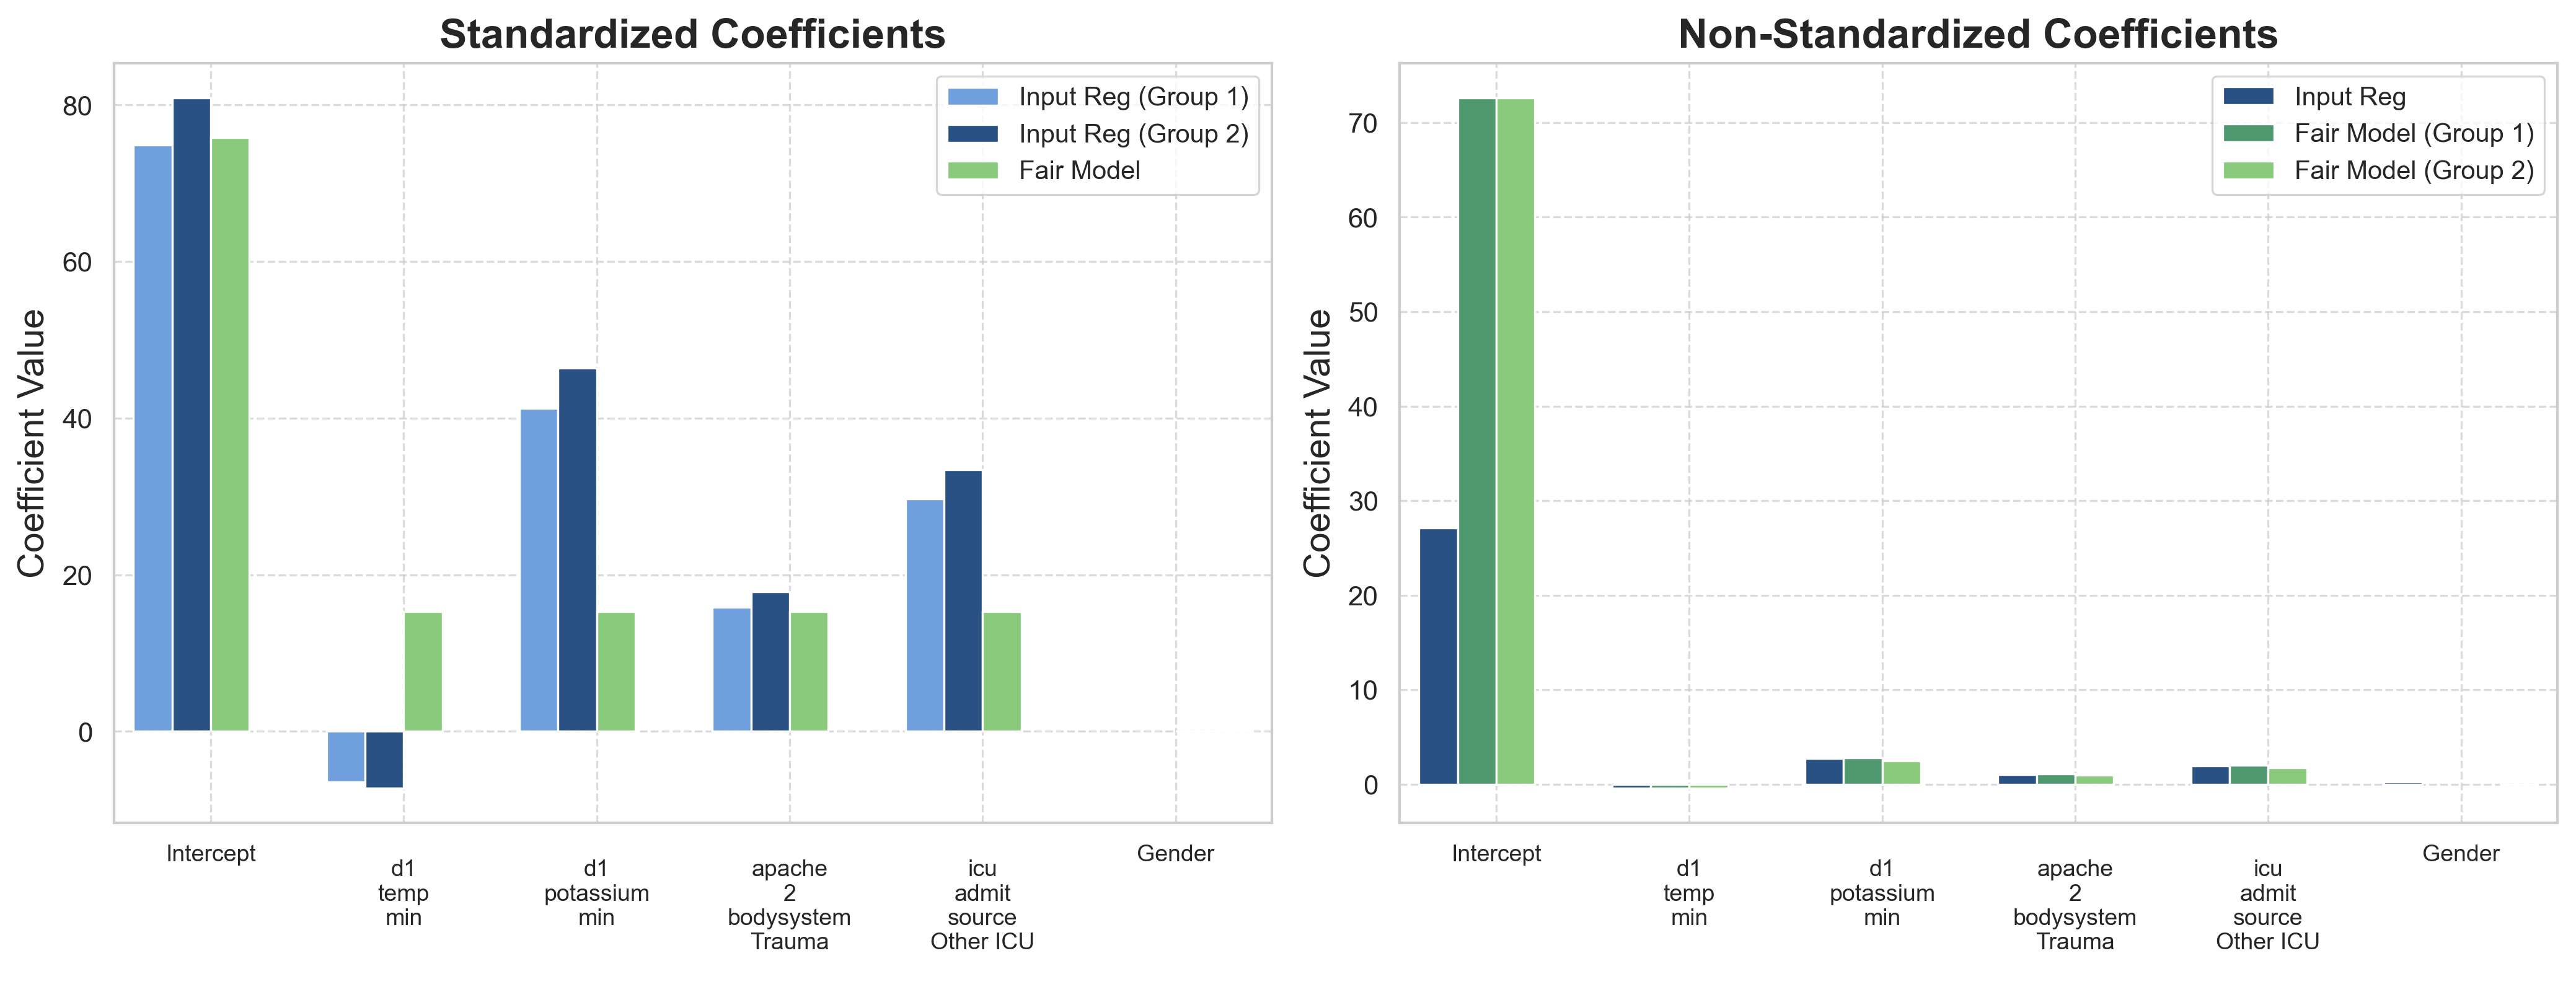

In [103]:
plot_comparison_coefficients(
    t_results, 
    S_variable="Gender",
    features_to_plot=[17, 28, 36, 43], 
    feature_names=[X_features[17],X_features[28], X_features[36], X_features[43]],
    name_figure="coeffs_multiline.png"
)